# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# from unityagents import UnityEnvironment
# import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# env = UnityEnvironment(file_name="Reacher_Linux_twenty_agents/Reacher.x86_64")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import os
from collections import deque
from typing import Deque, List

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from unityagents import UnityEnvironment

from agent import Agent
from agent_manager import AgentManager

Currently is using device: cuda
Currently is using device: cuda


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# env = UnityEnvironment(file_name="Reacher_Linux_single_agent/Reacher.x86_64")
env = UnityEnvironment(file_name="Reacher_Linux_twenty_agents/Reacher.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [10]:
def train_with_agent_manager(
    env,
    brain_name: str,
    agent_manager: AgentManager,
    n_episodes: int = 100,
    max_timestamp_per_episode: int = 1000,
    num_timestamp_per_print: int = 100,
) -> List[float]:
    scores_window = deque(maxlen=num_timestamp_per_print)
    scores_by_episode = []

    for episode_idx in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_manager.reset()
        scores = np.zeros(agent_manager.num_agents)

        for timestamp in range(max_timestamp_per_episode):
            actions = agent_manager.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = (
                env_info.vector_observations,
                env_info.rewards,
                env_info.local_done,
            )

            agent_manager.step(states, actions, rewards, next_states, dones, timestamp)

            states = next_states
            scores += rewards
            if np.any(dones):
                break

        average_score_by_episode = np.mean(scores)
        scores_window.append(average_score_by_episode)
        scores_by_episode.append(average_score_by_episode)
        average_score = np.mean(scores_window)

        print(f"Episode {episode_idx} -- Average score: {average_score}")

        if average_score >= 30.0:
            print(f"Problem solved within {episode_idx} episodes.")
            print(f"Average score: {average_score}")
    
    return scores_by_episode

In [11]:
def draw_scores(scores: List[float]) -> None:
    fig = plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.ylabel('Average score')
    plt.xlabel('Number of episodes')
    plt.show()

Episode 1 -- Average score: 0.23299999479204417
Episode 2 -- Average score: 0.3982499910984188
Episode 3 -- Average score: 0.6073333197583755
Episode 4 -- Average score: 0.790374982333742
Episode 5 -- Average score: 1.0140999773330985
Episode 6 -- Average score: 1.5800832980157187
Episode 7 -- Average score: 2.34764280466895
Episode 8 -- Average score: 4.1141249080421405
Episode 9 -- Average score: 6.012944310044663
Episode 10 -- Average score: 8.3674998129718
Episode 11 -- Average score: 10.748727032474497
Episode 12 -- Average score: 13.102666373799245
Episode 13 -- Average score: 15.114461200626998
Episode 14 -- Average score: 16.805749624362218
Episode 15 -- Average score: 18.276899591479452
Episode 16 -- Average score: 19.592249562079086
Episode 17 -- Average score: 20.737234830604315
Episode 18 -- Average score: 21.770277291174146
Episode 19 -- Average score: 22.68694686132826
Episode 20 -- Average score: 23.52522447417024
Episode 21 -- Average score: 24.28621374287509
Episode 22

Episode 92 -- Average score: 35.678064419924404
Problem solved within 92 episodes.
Average score: 35.678064419924404
Episode 93 -- Average score: 35.7165959758654
Problem solved within 93 episodes.
Average score: 35.7165959758654
Episode 94 -- Average score: 35.755797073136065
Problem solved within 94 episodes.
Average score: 35.755797073136065
Episode 95 -- Average score: 35.7910939368488
Problem solved within 95 episodes.
Average score: 35.7910939368488
Episode 96 -- Average score: 35.82652524088141
Problem solved within 96 episodes.
Average score: 35.82652524088141
Episode 97 -- Average score: 35.85809198201432
Problem solved within 97 episodes.
Average score: 35.85809198201432
Episode 98 -- Average score: 35.8819838918527
Problem solved within 98 episodes.
Average score: 35.8819838918527
Episode 99 -- Average score: 35.91139313671173
Problem solved within 99 episodes.
Average score: 35.91139313671173
Episode 100 -- Average score: 35.94424919658341
Problem solved within 100 episodes

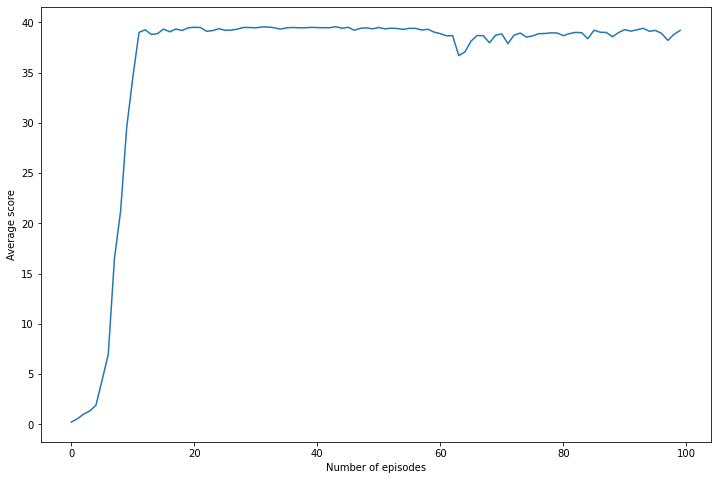

In [12]:
OVERWRITE = True
ACTOR_MODEL_FILE_PATH = "ddpg_actor_local.pt"
CRITIC_MODEL_FILE_PATH = "ddpg_critic_local.pt"

agent_manager = AgentManager(
    num_agents,
    state_size=brain.vector_observation_space_size,
    action_size=brain.vector_action_space_size,
    seed=514,
)

if (
    not OVERWRITE
    and os.path.exists(ACTOR_MODEL_FILE_PATH)
    and os.path.exists(CRITIC_MODEL_FILE_PATH)
):
    agent_manager.actor_local.load_state_dict(torch.load(ACTOR_MODEL_FILE_PATH))
    agent_manager.critic_local.load_state_dict(torch.load(CRITIC_MODEL_FILE_PATH))
else:
    scores_by_episode = train_with_agent_manager(env, brain_name, agent_manager)
    torch.save(agent_manager.actor_local.state_dict(), ACTOR_MODEL_FILE_PATH)
    torch.save(agent_manager.critic_local.state_dict(), CRITIC_MODEL_FILE_PATH)
    draw_scores(scores_by_episode)

In [13]:
torch.save(agent_manager.actor_local.state_dict(), ACTOR_MODEL_FILE_PATH)
torch.save(agent_manager.critic_local.state_dict(), ACTOR_MODEL_FILE_PATH)

In [14]:
env.close()